**TODO: put (parts of) this into paper and/or README.**

How parameter tuning works in our case:

Each evaluator has one or two numerical parameters that can be "tuned" in order to minimize a certain error. However, we have no mathematical model that can be trained in the classical ML sense. Instead, for every service, we try parameters from a parameter grid and consider this as "training" or "tuning".

We train the parameters using a 5-fold cross validation and report the average error on the test sets as the optimal error that can be achieved.

To make the tuning comparable across services, we build the parameter grids based on quantiles of the distributions of the tuning parameters. For every service and parameter we use a maximum of 20 parameter values as a default. (Note that depending on the distribution the number of the resulting parameter values can be less than 20.) For this step we consider only those responses where the API/service decided for 'f' or 'm' (so we ignore 'unknown' or similar). 

Finally, we train each evaluator on the entire data set to obtain the best parameter values for a given error.

In [4]:
import pandas as pd
import numpy as np
from evaluators import *
from evaluator import *
from helpers import REGISTERED_EVALUATORS, compute_equal_frequency_binning

import matplotlib.ticker as mtick
from mpltools import style
style.use('ggplot')
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/helena.mihaljevic-br/.virtualenvs/name-based-inference/lib/python3.5/site-packages/matplotlib/__init__.py:800: MatplotlibDeprecationWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  mplDeprecation)
/Users/helena.mihaljevic-br/.virtualenvs/name-based-inference/lib/python3.5/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['shuffle', 'style']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Compute errors without tuning

In [5]:
def compute_all_errors_without_tuning():
    service_to_all_errors = {}
    error_names = ['error_with_unknown', 'error_without_unknown', 'error_gender_bias', 'error_unknown', 
                  'weighted_error','f_precision', 'f_recall']
    
    for s in REGISTERED_EVALUATORS:  
        evaluator = s('all')
        eval_name = evaluator.gender_evaluator
        evaluator.load_data(evaluated=True)
        evaluator._translate_api_response()
        evaluator.compute_confusion_matrix(evaluator.test_data)
        errors = evaluator.compute_all_errors()
        service_to_all_errors[eval_name] = errors
    all_errors = pd.DataFrame.from_dict(service_to_all_errors, orient='index')
    all_errors.columns = error_names
    return all_errors

In [6]:
compute_all_errors_without_tuning()

,error_with_unknown,error_without_unknown,error_gender_bias,error_unknown,weighted_error,f_precision,f_recall
gender_api_full,0.204145,0.077108,-0.019027,0.137651,0.105659,0.911043,0.860870
namsor,0.135924,0.051384,0.010049,0.089119,0.069590,0.911184,0.938453
genderize_io,0.150432,0.058925,0.025253,0.097237,0.078770,0.886715,0.951381
names_api_full,0.186874,0.043284,0.007112,0.150086,0.075921,0.927865,0.947150
gender_guesser,0.229361,0.035243,0.005405,0.201209,0.081515,0.941360,0.956274
gender_api,0.086701,0.058405,-0.008191,0.030052,0.064203,0.924559,0.902350
names_api,0.237997,0.050161,0.010549,0.197755,0.094789,0.918308,0.945140


## Discretize distribution of tuning parameters

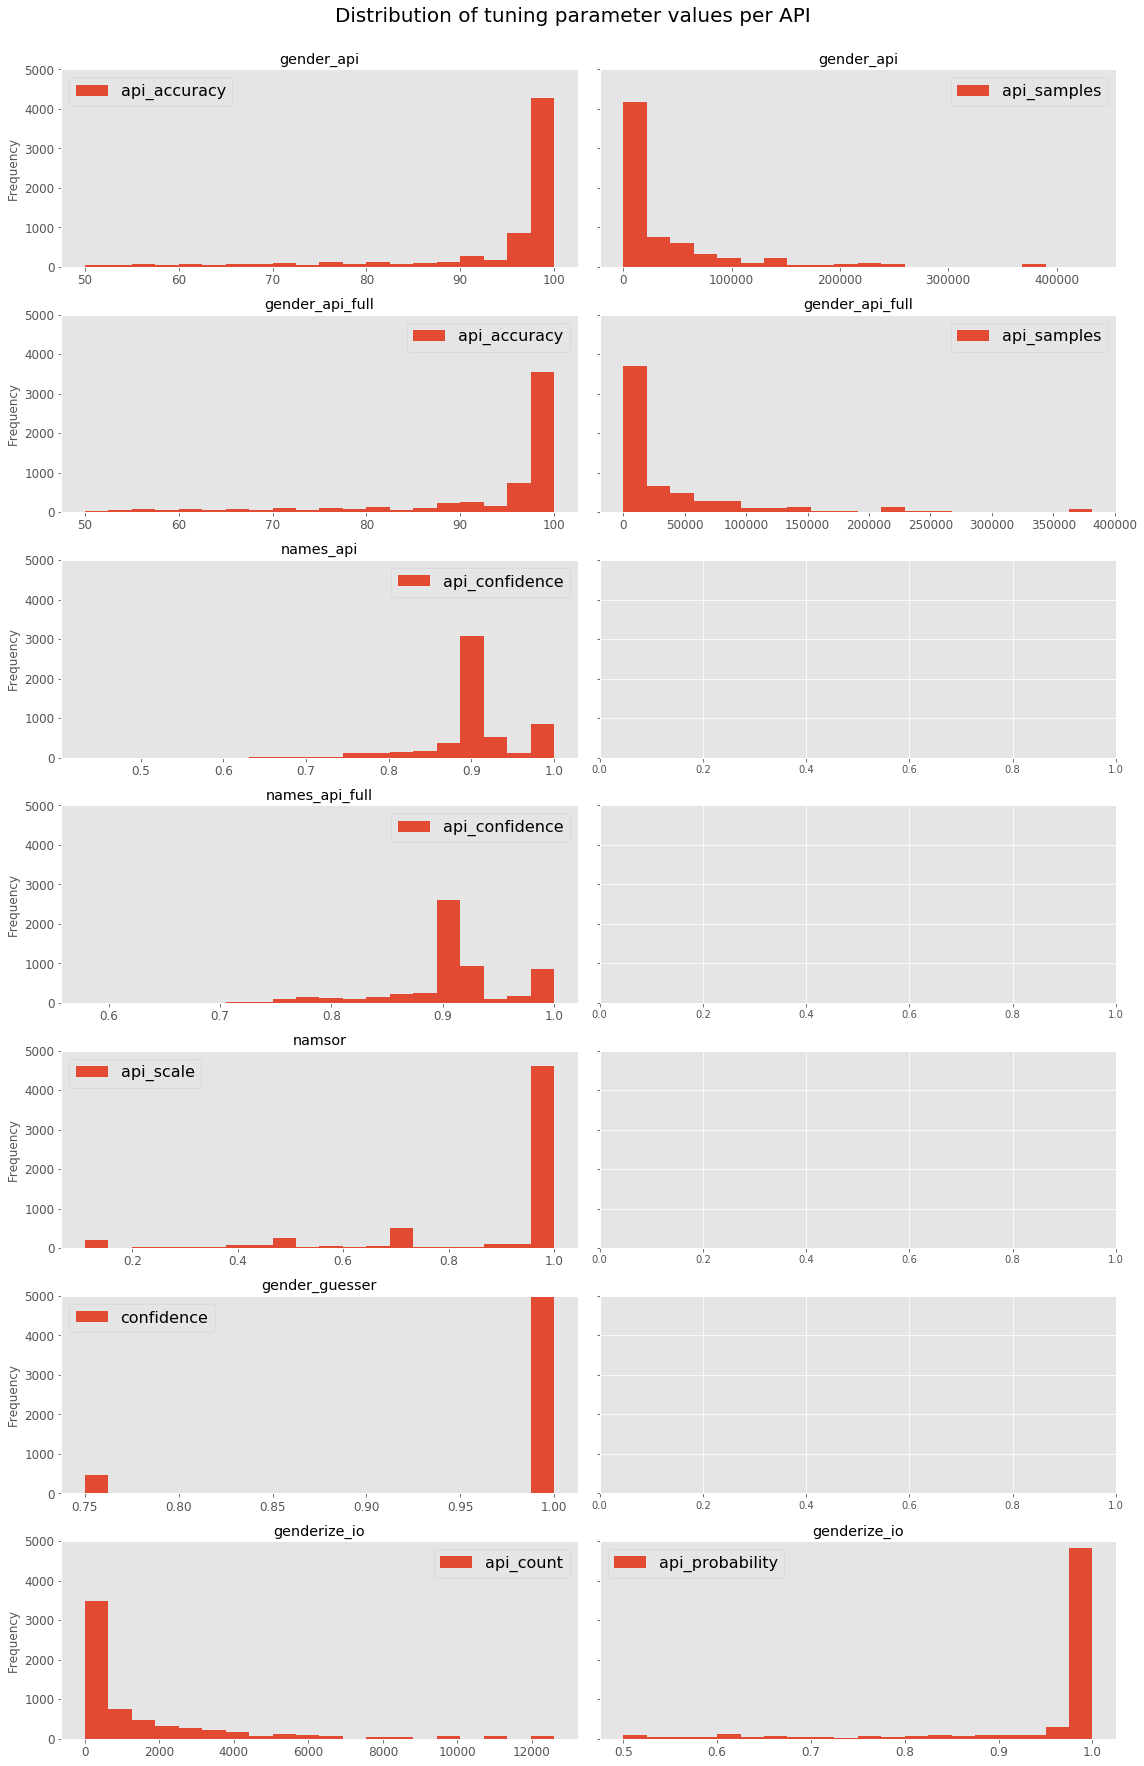

In [7]:
rows = len(REGISTERED_EVALUATORS)
cols = 2
fs=12
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(16, 24))
#cmap = plt.get_cmap('YlGnBu')

formatter = FuncFormatter(lambda v, pos: str(v * 100)) # from: https://github.com/matplotlib/matplotlib/issues/320/

for i, s in enumerate(REGISTERED_EVALUATORS):    
    evaluator = s('all')
    evaluator.load_data(evaluated=True)
    evaluator.preprocess_data_for_parameter_tuning()
    evaluator._translate_api_response()
    evaluator.remove_rows_with_unknown_gender(gender=False, gender_infered=True)
    for j, param in enumerate(list(evaluator.tuning_params)):
        evaluator.test_data[[param]].plot(ax=axes[i][j], kind='hist', stacked=False, title=s.gender_evaluator, 
                                         sharey=True, fontsize=fs, grid=False, bins=20, ylim=(0, 5000) #, normed=True
                                         )
        
        axes[i][j].legend(loc='best', fontsize=fs+4)
        #axes[i][j].yaxis.set_major_formatter(formatter)
        #axes[i][j].set_ylabel('')

plt.suptitle('Distribution of tuning parameter values per API', fontsize=20, y=1.02)

fig.tight_layout()

### Use quantiles

In [8]:
# test on genderize_io
evaluator = REGISTERED_EVALUATORS[-1]('all')
tuning_param = 'api_probability'

In [9]:
evaluator.load_data(evaluated=True)
evaluator.preprocess_data_for_parameter_tuning()
evaluator.remove_rows_with_unknown_gender(gender=False, gender_infered=True)

data = evaluator.test_data[tuning_param]
# add bins to df to check whether param_value lies in interval
evaluator.test_data['api_bins'] = pd.qcut(data, 5, duplicates='drop')

In [10]:
evaluator.test_data.head()

,index,first_name,middle_name,last_name,full_name,gender,origin,api_count,api_gender,api_name,api_probability,gender_infered,api_bins
0,0,pierre,paul,grivel,pierre paul grivel,m,zbmath,5.0,male,pierre-paul,1.00,m,"(0.99, 1.0]"
1,1,raul,,serapioni,raul serapioni,m,zbmath,821.0,male,raul,1.00,m,"(0.99, 1.0]"
2,2,adriano,,moura,adriano moura,m,zbmath,166.0,male,adriano,0.99,m,"(0.95, 0.99]"
3,3,ralf,,kieser,ralf kieser,m,zbmath,86.0,male,ralf,1.00,m,"(0.99, 1.0]"
4,5,guillermo,,leon-de-la-barra,guillermo leon-de-la-barra,m,zbmath,850.0,male,guillermo,1.00,m,"(0.99, 1.0]"


In [11]:
compute_equal_frequency_binning(evaluator.test_data[tuning_param], 5)

[0, 0.499, 0.94999999999999996, 0.98999999999999999]

In [12]:
compute_equal_frequency_binning(evaluator.test_data[tuning_param], 20)

[0,
 0.499,
 0.60999999999999999,
 0.76000000000000001,
 0.88,
 0.94999999999999996,
 0.97999999999999998,
 0.98999999999999999]

## Build parameter grids for all services

In [13]:
def build_grid_for_all_services(max_grid_points):
    service_to_grid_range = {}
    for s in REGISTERED_EVALUATORS:  
        evaluator = s('all')
        evaluator.load_data(evaluated=True)
        evaluator.preprocess_data_for_parameter_tuning()
        evaluator._translate_api_response()
        evaluator.remove_rows_with_unknown_gender(gender=False, gender_infered=True)
        grid_range = [compute_equal_frequency_binning(evaluator.test_data[param], max_grid_points) 
                      for param in list(evaluator.tuning_params)]
        service_to_grid_range[evaluator.gender_evaluator] = grid_range
        
    return service_to_grid_range

In [14]:
def check_density_of_grids(grids):
    # check how many parameter values we have per service
    for k,v in grids.items():
        print("Service name:", k)
        for i, param_range in enumerate(v):
            print(str(i+1) + ". tuning parameter:", len(param_range))

In [15]:
grid_30 = build_grid_for_all_services(30)
grid_20 = build_grid_for_all_services(20)

In [16]:
check_density_of_grids(grid_30)

Service name: gender_api_full
1. tuning parameter: 15
2. tuning parameter: 31
Service name: namsor
1. tuning parameter: 10
Service name: genderize_io
1. tuning parameter: 30
2. tuning parameter: 10
Service name: names_api_full
1. tuning parameter: 19
Service name: gender_guesser
1. tuning parameter: 2
Service name: gender_api
1. tuning parameter: 14
2. tuning parameter: 31
Service name: names_api
1. tuning parameter: 19


In [17]:
check_density_of_grids(grid_20)

Service name: gender_api_full
1. tuning parameter: 11
2. tuning parameter: 21
Service name: namsor
1. tuning parameter: 7
Service name: genderize_io
1. tuning parameter: 21
2. tuning parameter: 8
Service name: names_api_full
1. tuning parameter: 14
Service name: gender_guesser
1. tuning parameter: 2
Service name: gender_api
1. tuning parameter: 11
2. tuning parameter: 21
Service name: names_api
1. tuning parameter: 14


In [18]:
grid_20['gender_api']

[[0, 49.999000000000002, 64.0, 75.0, 84.0, 91.0, 95.0, 96.0, 97.0, 98.0, 99.0],
 [0,
  2.9990000000000001,
  18.0,
  82.0,
  255.0,
  580.0,
  1208.0,
  2064.0,
  3053.0,
  4788.0,
  7068.25,
  10383.0,
  14681.0,
  20555.0,
  27559.0,
  37520.0,
  48855.0,
  60103.0,
  82448.0,
  121922.0,
  179732.75]]

## Benchmark (with `grid_20`)

In [19]:
# Wrapper around some methods to make tuning with different error functions a one-liner
def prepare_for_tuning(e):
    e.load_data(evaluated=True)
    e.preprocess_data_for_parameter_tuning()
    e._translate_api_response()
    e.remove_rows_with_unknown_gender(gender=True, gender_infered=False)
    e.shuffle_data()
    return e

def tune(error_func, grids, constraint_func=None, constraint_val=None):
    service_to_test_error = {}
    for s in REGISTERED_EVALUATORS:  
        evaluator = s('all')
        evaluator_name = evaluator.gender_evaluator
        print(evaluator_name)

        evaluator = prepare_for_tuning(evaluator)

        grid_range = grids[evaluator_name]
        grid = evaluator.build_parameter_grid(*grid_range)
        mean_test_error = evaluator.compute_cv_score(n_splits=5, param_grid=grid, error_func=error_func, 
                                                    constraint_func=constraint_func, constraint_val=constraint_val)
        service_to_test_error[evaluator_name] = mean_test_error
    return service_to_test_error

## Errors from `genderizeR` paper

In [ ]:
error_with_unknown = tune(Evaluator.compute_error_with_unknown, grid_20)

gender_api
{'api_samples': 0, 'api_accuracy': 0}
{'api_samples': 2.9990000000000001, 'api_accuracy': 0}
{'api_samples': 18.0, 'api_accuracy': 0}
{'api_samples': 82.0, 'api_accuracy': 0}
{'api_samples': 255.0, 'api_accuracy': 0}
{'api_samples': 580.0, 'api_accuracy': 0}
{'api_samples': 1208.0, 'api_accuracy': 0}
{'api_samples': 2064.0, 'api_accuracy': 0}
{'api_samples': 3053.0, 'api_accuracy': 0}
{'api_samples': 4788.0, 'api_accuracy': 0}
{'api_samples': 7068.25, 'api_accuracy': 0}
{'api_samples': 10383.0, 'api_accuracy': 0}
{'api_samples': 14681.0, 'api_accuracy': 0}
{'api_samples': 20555.0, 'api_accuracy': 0}
{'api_samples': 27559.0, 'api_accuracy': 0}
{'api_samples': 37520.0, 'api_accuracy': 0}
{'api_samples': 48855.0, 'api_accuracy': 0}
{'api_samples': 60103.0, 'api_accuracy': 0}
{'api_samples': 82448.0, 'api_accuracy': 0}
{'api_samples': 121922.0, 'api_accuracy': 0}
{'api_samples': 179732.75, 'api_accuracy': 0}
{'api_samples': 0, 'api_accuracy': 49.999000000000002}
{'api_samples': 

{'api_samples': 580.0, 'api_accuracy': 97.0}
{'api_samples': 1208.0, 'api_accuracy': 97.0}
{'api_samples': 2064.0, 'api_accuracy': 97.0}
{'api_samples': 3053.0, 'api_accuracy': 97.0}
{'api_samples': 4788.0, 'api_accuracy': 97.0}
{'api_samples': 7068.25, 'api_accuracy': 97.0}
{'api_samples': 10383.0, 'api_accuracy': 97.0}
{'api_samples': 14681.0, 'api_accuracy': 97.0}
{'api_samples': 20555.0, 'api_accuracy': 97.0}
{'api_samples': 27559.0, 'api_accuracy': 97.0}
{'api_samples': 37520.0, 'api_accuracy': 97.0}
{'api_samples': 48855.0, 'api_accuracy': 97.0}
{'api_samples': 60103.0, 'api_accuracy': 97.0}
{'api_samples': 82448.0, 'api_accuracy': 97.0}
{'api_samples': 121922.0, 'api_accuracy': 97.0}
{'api_samples': 179732.75, 'api_accuracy': 97.0}
{'api_samples': 0, 'api_accuracy': 98.0}
{'api_samples': 2.9990000000000001, 'api_accuracy': 98.0}
{'api_samples': 18.0, 'api_accuracy': 98.0}
{'api_samples': 82.0, 'api_accuracy': 98.0}
{'api_samples': 255.0, 'api_accuracy': 98.0}
{'api_samples': 580

{'api_samples': 2064.0, 'api_accuracy': 91.0}
{'api_samples': 3053.0, 'api_accuracy': 91.0}
{'api_samples': 4788.0, 'api_accuracy': 91.0}
{'api_samples': 7068.25, 'api_accuracy': 91.0}
{'api_samples': 10383.0, 'api_accuracy': 91.0}
{'api_samples': 14681.0, 'api_accuracy': 91.0}
{'api_samples': 20555.0, 'api_accuracy': 91.0}
{'api_samples': 27559.0, 'api_accuracy': 91.0}
{'api_samples': 37520.0, 'api_accuracy': 91.0}
{'api_samples': 48855.0, 'api_accuracy': 91.0}
{'api_samples': 60103.0, 'api_accuracy': 91.0}
{'api_samples': 82448.0, 'api_accuracy': 91.0}
{'api_samples': 121922.0, 'api_accuracy': 91.0}
{'api_samples': 179732.75, 'api_accuracy': 91.0}
{'api_samples': 0, 'api_accuracy': 95.0}
{'api_samples': 2.9990000000000001, 'api_accuracy': 95.0}
{'api_samples': 18.0, 'api_accuracy': 95.0}
{'api_samples': 82.0, 'api_accuracy': 95.0}
{'api_samples': 255.0, 'api_accuracy': 95.0}
{'api_samples': 580.0, 'api_accuracy': 95.0}
{'api_samples': 1208.0, 'api_accuracy': 95.0}
{'api_samples': 206

{'api_samples': 2064.0, 'api_accuracy': 64.0}
{'api_samples': 3053.0, 'api_accuracy': 64.0}
{'api_samples': 4788.0, 'api_accuracy': 64.0}
{'api_samples': 7068.25, 'api_accuracy': 64.0}
{'api_samples': 10383.0, 'api_accuracy': 64.0}
{'api_samples': 14681.0, 'api_accuracy': 64.0}
{'api_samples': 20555.0, 'api_accuracy': 64.0}
{'api_samples': 27559.0, 'api_accuracy': 64.0}
{'api_samples': 37520.0, 'api_accuracy': 64.0}
{'api_samples': 48855.0, 'api_accuracy': 64.0}
{'api_samples': 60103.0, 'api_accuracy': 64.0}
{'api_samples': 82448.0, 'api_accuracy': 64.0}
{'api_samples': 121922.0, 'api_accuracy': 64.0}
{'api_samples': 179732.75, 'api_accuracy': 64.0}
{'api_samples': 0, 'api_accuracy': 75.0}
{'api_samples': 2.9990000000000001, 'api_accuracy': 75.0}
{'api_samples': 18.0, 'api_accuracy': 75.0}
{'api_samples': 82.0, 'api_accuracy': 75.0}
{'api_samples': 255.0, 'api_accuracy': 75.0}
{'api_samples': 580.0, 'api_accuracy': 75.0}
{'api_samples': 1208.0, 'api_accuracy': 75.0}
{'api_samples': 206

{'api_samples': 48855.0, 'api_accuracy': 99.0}
{'api_samples': 60103.0, 'api_accuracy': 99.0}
{'api_samples': 82448.0, 'api_accuracy': 99.0}
{'api_samples': 121922.0, 'api_accuracy': 99.0}
{'api_samples': 179732.75, 'api_accuracy': 99.0}
minimal train error: 0.0865716753022 corresponding test error: 0.087219343696
params for lowest train error: {'api_samples': 0, 'api_accuracy': 64.0}
{'api_samples': 0, 'api_accuracy': 0}
{'api_samples': 2.9990000000000001, 'api_accuracy': 0}
{'api_samples': 18.0, 'api_accuracy': 0}
{'api_samples': 82.0, 'api_accuracy': 0}
{'api_samples': 255.0, 'api_accuracy': 0}
{'api_samples': 580.0, 'api_accuracy': 0}
{'api_samples': 1208.0, 'api_accuracy': 0}
{'api_samples': 2064.0, 'api_accuracy': 0}
{'api_samples': 3053.0, 'api_accuracy': 0}
{'api_samples': 4788.0, 'api_accuracy': 0}
{'api_samples': 7068.25, 'api_accuracy': 0}
{'api_samples': 10383.0, 'api_accuracy': 0}
{'api_samples': 14681.0, 'api_accuracy': 0}
{'api_samples': 20555.0, 'api_accuracy': 0}
{'api

{'api_samples': 179732.75, 'api_accuracy': 96.0}
{'api_samples': 0, 'api_accuracy': 97.0}
{'api_samples': 2.9990000000000001, 'api_accuracy': 97.0}
{'api_samples': 18.0, 'api_accuracy': 97.0}
{'api_samples': 82.0, 'api_accuracy': 97.0}
{'api_samples': 255.0, 'api_accuracy': 97.0}
{'api_samples': 580.0, 'api_accuracy': 97.0}
{'api_samples': 1208.0, 'api_accuracy': 97.0}
{'api_samples': 2064.0, 'api_accuracy': 97.0}
{'api_samples': 3053.0, 'api_accuracy': 97.0}
{'api_samples': 4788.0, 'api_accuracy': 97.0}
{'api_samples': 7068.25, 'api_accuracy': 97.0}
{'api_samples': 10383.0, 'api_accuracy': 97.0}
{'api_samples': 14681.0, 'api_accuracy': 97.0}
{'api_samples': 20555.0, 'api_accuracy': 97.0}
{'api_samples': 27559.0, 'api_accuracy': 97.0}
{'api_samples': 37520.0, 'api_accuracy': 97.0}
{'api_samples': 48855.0, 'api_accuracy': 97.0}
{'api_samples': 60103.0, 'api_accuracy': 97.0}
{'api_samples': 82448.0, 'api_accuracy': 97.0}
{'api_samples': 121922.0, 'api_accuracy': 97.0}
{'api_samples': 179

{'api_samples': 121922.0, 'api_accuracy': 84.0}
{'api_samples': 179732.75, 'api_accuracy': 84.0}
{'api_samples': 0, 'api_accuracy': 91.0}
{'api_samples': 2.9990000000000001, 'api_accuracy': 91.0}
{'api_samples': 18.0, 'api_accuracy': 91.0}
{'api_samples': 82.0, 'api_accuracy': 91.0}
{'api_samples': 255.0, 'api_accuracy': 91.0}
{'api_samples': 580.0, 'api_accuracy': 91.0}
{'api_samples': 1208.0, 'api_accuracy': 91.0}
{'api_samples': 2064.0, 'api_accuracy': 91.0}
{'api_samples': 3053.0, 'api_accuracy': 91.0}
{'api_samples': 4788.0, 'api_accuracy': 91.0}
{'api_samples': 7068.25, 'api_accuracy': 91.0}
{'api_samples': 10383.0, 'api_accuracy': 91.0}
{'api_samples': 14681.0, 'api_accuracy': 91.0}
{'api_samples': 20555.0, 'api_accuracy': 91.0}
{'api_samples': 27559.0, 'api_accuracy': 91.0}
{'api_samples': 37520.0, 'api_accuracy': 91.0}
{'api_samples': 48855.0, 'api_accuracy': 91.0}
{'api_samples': 60103.0, 'api_accuracy': 91.0}
{'api_samples': 82448.0, 'api_accuracy': 91.0}
{'api_samples': 121

{'api_samples': 59951.0, 'api_accuracy': 49.999000000000002}
{'api_samples': 83764.199999999997, 'api_accuracy': 49.999000000000002}
{'api_samples': 104026.0, 'api_accuracy': 49.999000000000002}
{'api_samples': 163073.0, 'api_accuracy': 49.999000000000002}
{'api_samples': 0, 'api_accuracy': 63.0}
{'api_samples': 2.9990000000000001, 'api_accuracy': 63.0}
{'api_samples': 12.0, 'api_accuracy': 63.0}
{'api_samples': 51.0, 'api_accuracy': 63.0}
{'api_samples': 154.0, 'api_accuracy': 63.0}
{'api_samples': 353.39999999999998, 'api_accuracy': 63.0}
{'api_samples': 696.0, 'api_accuracy': 63.0}
{'api_samples': 1270.8, 'api_accuracy': 63.0}
{'api_samples': 2107.4000000000001, 'api_accuracy': 63.0}
{'api_samples': 3415.8000000000002, 'api_accuracy': 63.0}
{'api_samples': 5041.0, 'api_accuracy': 63.0}
{'api_samples': 8399.0, 'api_accuracy': 63.0}
{'api_samples': 12793.200000000001, 'api_accuracy': 63.0}
{'api_samples': 18194.0, 'api_accuracy': 63.0}
{'api_samples': 24530.0, 'api_accuracy': 63.0}
{'

{'api_samples': 24530.0, 'api_accuracy': 98.0}
{'api_samples': 34849.0, 'api_accuracy': 98.0}
{'api_samples': 48002.0, 'api_accuracy': 98.0}
{'api_samples': 59951.0, 'api_accuracy': 98.0}
{'api_samples': 83764.199999999997, 'api_accuracy': 98.0}
{'api_samples': 104026.0, 'api_accuracy': 98.0}
{'api_samples': 163073.0, 'api_accuracy': 98.0}
{'api_samples': 0, 'api_accuracy': 99.0}
{'api_samples': 2.9990000000000001, 'api_accuracy': 99.0}
{'api_samples': 12.0, 'api_accuracy': 99.0}
{'api_samples': 51.0, 'api_accuracy': 99.0}
{'api_samples': 154.0, 'api_accuracy': 99.0}
{'api_samples': 353.39999999999998, 'api_accuracy': 99.0}
{'api_samples': 696.0, 'api_accuracy': 99.0}
{'api_samples': 1270.8, 'api_accuracy': 99.0}
{'api_samples': 2107.4000000000001, 'api_accuracy': 99.0}
{'api_samples': 3415.8000000000002, 'api_accuracy': 99.0}
{'api_samples': 5041.0, 'api_accuracy': 99.0}
{'api_samples': 8399.0, 'api_accuracy': 99.0}
{'api_samples': 12793.200000000001, 'api_accuracy': 99.0}
{'api_sampl

{'api_samples': 696.0, 'api_accuracy': 91.0}
{'api_samples': 1270.8, 'api_accuracy': 91.0}
{'api_samples': 2107.4000000000001, 'api_accuracy': 91.0}
{'api_samples': 3415.8000000000002, 'api_accuracy': 91.0}
{'api_samples': 5041.0, 'api_accuracy': 91.0}
{'api_samples': 8399.0, 'api_accuracy': 91.0}
{'api_samples': 12793.200000000001, 'api_accuracy': 91.0}
{'api_samples': 18194.0, 'api_accuracy': 91.0}
{'api_samples': 24530.0, 'api_accuracy': 91.0}
{'api_samples': 34849.0, 'api_accuracy': 91.0}
{'api_samples': 48002.0, 'api_accuracy': 91.0}
{'api_samples': 59951.0, 'api_accuracy': 91.0}
{'api_samples': 83764.199999999997, 'api_accuracy': 91.0}
{'api_samples': 104026.0, 'api_accuracy': 91.0}
{'api_samples': 163073.0, 'api_accuracy': 91.0}
{'api_samples': 0, 'api_accuracy': 95.0}
{'api_samples': 2.9990000000000001, 'api_accuracy': 95.0}
{'api_samples': 12.0, 'api_accuracy': 95.0}
{'api_samples': 51.0, 'api_accuracy': 95.0}
{'api_samples': 154.0, 'api_accuracy': 95.0}
{'api_samples': 353.39

{'api_samples': 104026.0, 'api_accuracy': 63.0}
{'api_samples': 163073.0, 'api_accuracy': 63.0}
{'api_samples': 0, 'api_accuracy': 72.0}
{'api_samples': 2.9990000000000001, 'api_accuracy': 72.0}
{'api_samples': 12.0, 'api_accuracy': 72.0}
{'api_samples': 51.0, 'api_accuracy': 72.0}
{'api_samples': 154.0, 'api_accuracy': 72.0}
{'api_samples': 353.39999999999998, 'api_accuracy': 72.0}
{'api_samples': 696.0, 'api_accuracy': 72.0}
{'api_samples': 1270.8, 'api_accuracy': 72.0}
{'api_samples': 2107.4000000000001, 'api_accuracy': 72.0}
{'api_samples': 3415.8000000000002, 'api_accuracy': 72.0}
{'api_samples': 5041.0, 'api_accuracy': 72.0}
{'api_samples': 8399.0, 'api_accuracy': 72.0}
{'api_samples': 12793.200000000001, 'api_accuracy': 72.0}
{'api_samples': 18194.0, 'api_accuracy': 72.0}
{'api_samples': 24530.0, 'api_accuracy': 72.0}
{'api_samples': 34849.0, 'api_accuracy': 72.0}
{'api_samples': 48002.0, 'api_accuracy': 72.0}
{'api_samples': 59951.0, 'api_accuracy': 72.0}
{'api_samples': 83764.

{'api_samples': 163073.0, 'api_accuracy': 99.0}
minimal train error: 0.204015544041 corresponding test error: 0.204663212435
params for lowest train error: {'api_samples': 5041.0, 'api_accuracy': 0}
{'api_samples': 0, 'api_accuracy': 0}
{'api_samples': 2.9990000000000001, 'api_accuracy': 0}
{'api_samples': 12.0, 'api_accuracy': 0}
{'api_samples': 51.0, 'api_accuracy': 0}
{'api_samples': 154.0, 'api_accuracy': 0}
{'api_samples': 353.39999999999998, 'api_accuracy': 0}
{'api_samples': 696.0, 'api_accuracy': 0}
{'api_samples': 1270.8, 'api_accuracy': 0}
{'api_samples': 2107.4000000000001, 'api_accuracy': 0}
{'api_samples': 3415.8000000000002, 'api_accuracy': 0}
{'api_samples': 5041.0, 'api_accuracy': 0}
{'api_samples': 8399.0, 'api_accuracy': 0}
{'api_samples': 12793.200000000001, 'api_accuracy': 0}
{'api_samples': 18194.0, 'api_accuracy': 0}
{'api_samples': 24530.0, 'api_accuracy': 0}
{'api_samples': 34849.0, 'api_accuracy': 0}
{'api_samples': 48002.0, 'api_accuracy': 0}
{'api_samples': 5

{'api_samples': 12793.200000000001, 'api_accuracy': 95.0}
{'api_samples': 18194.0, 'api_accuracy': 95.0}
{'api_samples': 24530.0, 'api_accuracy': 95.0}
{'api_samples': 34849.0, 'api_accuracy': 95.0}
{'api_samples': 48002.0, 'api_accuracy': 95.0}
{'api_samples': 59951.0, 'api_accuracy': 95.0}
{'api_samples': 83764.199999999997, 'api_accuracy': 95.0}
{'api_samples': 104026.0, 'api_accuracy': 95.0}
{'api_samples': 163073.0, 'api_accuracy': 95.0}
{'api_samples': 0, 'api_accuracy': 97.0}
{'api_samples': 2.9990000000000001, 'api_accuracy': 97.0}
{'api_samples': 12.0, 'api_accuracy': 97.0}
{'api_samples': 51.0, 'api_accuracy': 97.0}
{'api_samples': 154.0, 'api_accuracy': 97.0}
{'api_samples': 353.39999999999998, 'api_accuracy': 97.0}
{'api_samples': 696.0, 'api_accuracy': 97.0}
{'api_samples': 1270.8, 'api_accuracy': 97.0}
{'api_samples': 2107.4000000000001, 'api_accuracy': 97.0}
{'api_samples': 3415.8000000000002, 'api_accuracy': 97.0}
{'api_samples': 5041.0, 'api_accuracy': 97.0}
{'api_samp

{'api_samples': 154.0, 'api_accuracy': 81.0}
{'api_samples': 353.39999999999998, 'api_accuracy': 81.0}
{'api_samples': 696.0, 'api_accuracy': 81.0}
{'api_samples': 1270.8, 'api_accuracy': 81.0}
{'api_samples': 2107.4000000000001, 'api_accuracy': 81.0}
{'api_samples': 3415.8000000000002, 'api_accuracy': 81.0}
{'api_samples': 5041.0, 'api_accuracy': 81.0}
{'api_samples': 8399.0, 'api_accuracy': 81.0}
{'api_samples': 12793.200000000001, 'api_accuracy': 81.0}
{'api_samples': 18194.0, 'api_accuracy': 81.0}
{'api_samples': 24530.0, 'api_accuracy': 81.0}
{'api_samples': 34849.0, 'api_accuracy': 81.0}
{'api_samples': 48002.0, 'api_accuracy': 81.0}
{'api_samples': 59951.0, 'api_accuracy': 81.0}
{'api_samples': 83764.199999999997, 'api_accuracy': 81.0}
{'api_samples': 104026.0, 'api_accuracy': 81.0}
{'api_samples': 163073.0, 'api_accuracy': 81.0}
{'api_samples': 0, 'api_accuracy': 88.0}
{'api_samples': 2.9990000000000001, 'api_accuracy': 88.0}
{'api_samples': 12.0, 'api_accuracy': 88.0}
{'api_sa

{'api_probability': 0.94999999999999996, 'api_count': 64.0}
{'api_probability': 0.97999999999999998, 'api_count': 64.0}
{'api_probability': 0.98999999999999999, 'api_count': 64.0}
{'api_probability': 0, 'api_count': 94.150000000000006}
{'api_probability': 0.499, 'api_count': 94.150000000000006}
{'api_probability': 0.60999999999999999, 'api_count': 94.150000000000006}
{'api_probability': 0.76000000000000001, 'api_count': 94.150000000000006}
{'api_probability': 0.88, 'api_count': 94.150000000000006}
{'api_probability': 0.94999999999999996, 'api_count': 94.150000000000006}
{'api_probability': 0.97999999999999998, 'api_count': 94.150000000000006}
{'api_probability': 0.98999999999999999, 'api_count': 94.150000000000006}
{'api_probability': 0, 'api_count': 151.0}
{'api_probability': 0.499, 'api_count': 151.0}
{'api_probability': 0.60999999999999999, 'api_count': 151.0}
{'api_probability': 0.76000000000000001, 'api_count': 151.0}
{'api_probability': 0.88, 'api_count': 151.0}
{'api_probability

{'api_probability': 0.94999999999999996, 'api_count': 13.0}
{'api_probability': 0.97999999999999998, 'api_count': 13.0}
{'api_probability': 0.98999999999999999, 'api_count': 13.0}
{'api_probability': 0, 'api_count': 24.0}
{'api_probability': 0.499, 'api_count': 24.0}
{'api_probability': 0.60999999999999999, 'api_count': 24.0}
{'api_probability': 0.76000000000000001, 'api_count': 24.0}
{'api_probability': 0.88, 'api_count': 24.0}
{'api_probability': 0.94999999999999996, 'api_count': 24.0}
{'api_probability': 0.97999999999999998, 'api_count': 24.0}
{'api_probability': 0.98999999999999999, 'api_count': 24.0}
{'api_probability': 0, 'api_count': 39.0}
{'api_probability': 0.499, 'api_count': 39.0}
{'api_probability': 0.60999999999999999, 'api_count': 39.0}
{'api_probability': 0.76000000000000001, 'api_count': 39.0}
{'api_probability': 0.88, 'api_count': 39.0}
{'api_probability': 0.94999999999999996, 'api_count': 39.0}
{'api_probability': 0.97999999999999998, 'api_count': 39.0}
{'api_probabil

{'api_probability': 0.88, 'api_count': 0.999}
{'api_probability': 0.94999999999999996, 'api_count': 0.999}
{'api_probability': 0.97999999999999998, 'api_count': 0.999}
{'api_probability': 0.98999999999999999, 'api_count': 0.999}
{'api_probability': 0, 'api_count': 2.0}
{'api_probability': 0.499, 'api_count': 2.0}
{'api_probability': 0.60999999999999999, 'api_count': 2.0}
{'api_probability': 0.76000000000000001, 'api_count': 2.0}
{'api_probability': 0.88, 'api_count': 2.0}
{'api_probability': 0.94999999999999996, 'api_count': 2.0}
{'api_probability': 0.97999999999999998, 'api_count': 2.0}
{'api_probability': 0.98999999999999999, 'api_count': 2.0}
{'api_probability': 0, 'api_count': 5.0}
{'api_probability': 0.499, 'api_count': 5.0}
{'api_probability': 0.60999999999999999, 'api_count': 5.0}
{'api_probability': 0.76000000000000001, 'api_count': 5.0}
{'api_probability': 0.88, 'api_count': 5.0}
{'api_probability': 0.94999999999999996, 'api_count': 5.0}
{'api_probability': 0.97999999999999998

{'api_probability': 0, 'api_count': 7396.8000000000002}
{'api_probability': 0.499, 'api_count': 7396.8000000000002}
{'api_probability': 0.60999999999999999, 'api_count': 7396.8000000000002}
{'api_probability': 0.76000000000000001, 'api_count': 7396.8000000000002}
{'api_probability': 0.88, 'api_count': 7396.8000000000002}
{'api_probability': 0.94999999999999996, 'api_count': 7396.8000000000002}
{'api_probability': 0.97999999999999998, 'api_count': 7396.8000000000002}
{'api_probability': 0.98999999999999999, 'api_count': 7396.8000000000002}
minimal train error: 0.148100172712 corresponding test error: 0.1597582038
params for lowest train error: {'api_probability': 0, 'api_count': 39.0}
{'api_probability': 0, 'api_count': 0}
{'api_probability': 0.499, 'api_count': 0}
{'api_probability': 0.60999999999999999, 'api_count': 0}
{'api_probability': 0.76000000000000001, 'api_count': 0}
{'api_probability': 0.88, 'api_count': 0}
{'api_probability': 0.94999999999999996, 'api_count': 0}
{'api_probab

{'api_probability': 0.98999999999999999, 'api_count': 2010.0}
{'api_probability': 0, 'api_count': 2548.0}
{'api_probability': 0.499, 'api_count': 2548.0}
{'api_probability': 0.60999999999999999, 'api_count': 2548.0}
{'api_probability': 0.76000000000000001, 'api_count': 2548.0}
{'api_probability': 0.88, 'api_count': 2548.0}
{'api_probability': 0.94999999999999996, 'api_count': 2548.0}
{'api_probability': 0.97999999999999998, 'api_count': 2548.0}
{'api_probability': 0.98999999999999999, 'api_count': 2548.0}
{'api_probability': 0, 'api_count': 3508.0}
{'api_probability': 0.499, 'api_count': 3508.0}
{'api_probability': 0.60999999999999999, 'api_count': 3508.0}
{'api_probability': 0.76000000000000001, 'api_count': 3508.0}
{'api_probability': 0.88, 'api_count': 3508.0}
{'api_probability': 0.94999999999999996, 'api_count': 3508.0}
{'api_probability': 0.97999999999999998, 'api_count': 3508.0}
{'api_probability': 0.98999999999999999, 'api_count': 3508.0}
{'api_probability': 0, 'api_count': 4584

{'api_probability': 0.499, 'api_count': 1118.05}
{'api_probability': 0.60999999999999999, 'api_count': 1118.05}
{'api_probability': 0.76000000000000001, 'api_count': 1118.05}
{'api_probability': 0.88, 'api_count': 1118.05}
{'api_probability': 0.94999999999999996, 'api_count': 1118.05}
{'api_probability': 0.97999999999999998, 'api_count': 1118.05}
{'api_probability': 0.98999999999999999, 'api_count': 1118.05}
{'api_probability': 0, 'api_count': 1523.0}
{'api_probability': 0.499, 'api_count': 1523.0}
{'api_probability': 0.60999999999999999, 'api_count': 1523.0}
{'api_probability': 0.76000000000000001, 'api_count': 1523.0}
{'api_probability': 0.88, 'api_count': 1523.0}
{'api_probability': 0.94999999999999996, 'api_count': 1523.0}
{'api_probability': 0.97999999999999998, 'api_count': 1523.0}
{'api_probability': 0.98999999999999999, 'api_count': 1523.0}
{'api_probability': 0, 'api_count': 2010.0}
{'api_probability': 0.499, 'api_count': 2010.0}
{'api_probability': 0.60999999999999999, 'api_c

**Best result is achieved by `gender_api` with an average test error 0.0867013837581. Second best is `namsor` with 0.135923449219. All services achieve their best result at or near the left boundary of the parameter grid.**

In [ ]:
error_without_unknown = tune(Evaluator.compute_error_without_unknown, grid_20)

gender_api
{'api_samples': 0, 'api_accuracy': 0}
{'api_samples': 2.9990000000000001, 'api_accuracy': 0}
{'api_samples': 18.0, 'api_accuracy': 0}
{'api_samples': 82.0, 'api_accuracy': 0}
{'api_samples': 255.0, 'api_accuracy': 0}
{'api_samples': 580.0, 'api_accuracy': 0}
{'api_samples': 1208.0, 'api_accuracy': 0}
{'api_samples': 2064.0, 'api_accuracy': 0}
{'api_samples': 3053.0, 'api_accuracy': 0}
{'api_samples': 4788.0, 'api_accuracy': 0}
{'api_samples': 7068.25, 'api_accuracy': 0}
{'api_samples': 10383.0, 'api_accuracy': 0}
{'api_samples': 14681.0, 'api_accuracy': 0}
{'api_samples': 20555.0, 'api_accuracy': 0}
{'api_samples': 27559.0, 'api_accuracy': 0}
{'api_samples': 37520.0, 'api_accuracy': 0}
{'api_samples': 48855.0, 'api_accuracy': 0}
{'api_samples': 60103.0, 'api_accuracy': 0}
{'api_samples': 82448.0, 'api_accuracy': 0}
{'api_samples': 121922.0, 'api_accuracy': 0}
{'api_samples': 179732.75, 'api_accuracy': 0}
{'api_samples': 0, 'api_accuracy': 49.999000000000002}
{'api_samples': 

{'api_samples': 580.0, 'api_accuracy': 97.0}
{'api_samples': 1208.0, 'api_accuracy': 97.0}
{'api_samples': 2064.0, 'api_accuracy': 97.0}
{'api_samples': 3053.0, 'api_accuracy': 97.0}
{'api_samples': 4788.0, 'api_accuracy': 97.0}
{'api_samples': 7068.25, 'api_accuracy': 97.0}
{'api_samples': 10383.0, 'api_accuracy': 97.0}
{'api_samples': 14681.0, 'api_accuracy': 97.0}
{'api_samples': 20555.0, 'api_accuracy': 97.0}
{'api_samples': 27559.0, 'api_accuracy': 97.0}
{'api_samples': 37520.0, 'api_accuracy': 97.0}
{'api_samples': 48855.0, 'api_accuracy': 97.0}
{'api_samples': 60103.0, 'api_accuracy': 97.0}
{'api_samples': 82448.0, 'api_accuracy': 97.0}
{'api_samples': 121922.0, 'api_accuracy': 97.0}
{'api_samples': 179732.75, 'api_accuracy': 97.0}
{'api_samples': 0, 'api_accuracy': 98.0}
{'api_samples': 2.9990000000000001, 'api_accuracy': 98.0}
{'api_samples': 18.0, 'api_accuracy': 98.0}
{'api_samples': 82.0, 'api_accuracy': 98.0}
{'api_samples': 255.0, 'api_accuracy': 98.0}
{'api_samples': 580

{'api_samples': 255.0, 'api_accuracy': 91.0}
{'api_samples': 580.0, 'api_accuracy': 91.0}
{'api_samples': 1208.0, 'api_accuracy': 91.0}
{'api_samples': 2064.0, 'api_accuracy': 91.0}
{'api_samples': 3053.0, 'api_accuracy': 91.0}
{'api_samples': 4788.0, 'api_accuracy': 91.0}
{'api_samples': 7068.25, 'api_accuracy': 91.0}
{'api_samples': 10383.0, 'api_accuracy': 91.0}
{'api_samples': 14681.0, 'api_accuracy': 91.0}
{'api_samples': 20555.0, 'api_accuracy': 91.0}
{'api_samples': 27559.0, 'api_accuracy': 91.0}
{'api_samples': 37520.0, 'api_accuracy': 91.0}
{'api_samples': 48855.0, 'api_accuracy': 91.0}
{'api_samples': 60103.0, 'api_accuracy': 91.0}
{'api_samples': 82448.0, 'api_accuracy': 91.0}
{'api_samples': 121922.0, 'api_accuracy': 91.0}
{'api_samples': 179732.75, 'api_accuracy': 91.0}
{'api_samples': 0, 'api_accuracy': 95.0}
{'api_samples': 2.9990000000000001, 'api_accuracy': 95.0}
{'api_samples': 18.0, 'api_accuracy': 95.0}
{'api_samples': 82.0, 'api_accuracy': 95.0}
{'api_samples': 255

{'api_samples': 82.0, 'api_accuracy': 64.0}
{'api_samples': 255.0, 'api_accuracy': 64.0}
{'api_samples': 580.0, 'api_accuracy': 64.0}
{'api_samples': 1208.0, 'api_accuracy': 64.0}
{'api_samples': 2064.0, 'api_accuracy': 64.0}
{'api_samples': 3053.0, 'api_accuracy': 64.0}
{'api_samples': 4788.0, 'api_accuracy': 64.0}
{'api_samples': 7068.25, 'api_accuracy': 64.0}
{'api_samples': 10383.0, 'api_accuracy': 64.0}
{'api_samples': 14681.0, 'api_accuracy': 64.0}
{'api_samples': 20555.0, 'api_accuracy': 64.0}
{'api_samples': 27559.0, 'api_accuracy': 64.0}
{'api_samples': 37520.0, 'api_accuracy': 64.0}
{'api_samples': 48855.0, 'api_accuracy': 64.0}
{'api_samples': 60103.0, 'api_accuracy': 64.0}
{'api_samples': 82448.0, 'api_accuracy': 64.0}
{'api_samples': 121922.0, 'api_accuracy': 64.0}
{'api_samples': 179732.75, 'api_accuracy': 64.0}
{'api_samples': 0, 'api_accuracy': 75.0}
{'api_samples': 2.9990000000000001, 'api_accuracy': 75.0}
{'api_samples': 18.0, 'api_accuracy': 75.0}
{'api_samples': 82.

**Best result is achieved by `gender_api` with an average test error 0.0. Second best is `genderize_io` with 0.00377358490566. Several other services follow with very low errors as well. All services achieve their best result at or near the right boundary of the parameter grid.**

In [ ]:
error_unknown = tune(Evaluator.compute_error_unknown, grid_20)

**Best result is achieved by `gender_api` with an average test error 0.0300509278656. Second best is `namsor` with 0.0891206876941. All services achieve their best result at or near the left boundary of the parameter grid.**

**Behaves like `error_with_unknown`.**

In [ ]:
error_gender_bias = tune(Evaluator.compute_error_gender_bias, grid_20)

**Best result is achieved by `gender_api` with an average test error 0.0. Second best is `genderize_io` with 0.00377358490566. All services achieve their best result at or near the right boundary of the parameter grid.**

**Behaves like `error_without_unknown`.**

## Weighted error

This is a version of `error_with_unknown` where we put a weight of 0.2 on the names with true gender being 'f' or 'm' but classified as 'unknown'.

In [ ]:
weighted_error = tune(Evaluator.compute_weighted_error, grid_20)

**Best result is achieved by `gender_api` with an average test error 0.0525162309993. Second best is `namsor` with 0.0640116391787. Several other services follow with very low errors as well.** 


## Minimize `error_with_unknown` with a constraint on the maximal value of `error_without_unknown`

In [ ]:
constraint_error = tune(error_func=Evaluator.compute_error_with_unknown, grids=grid_20, 
                      constraint_func=Evaluator.compute_error_without_unknown, constraint_val=0.05)

**Best result is achieved by `gender_api` with an average test error 0.105872671659. Second best is `namsor` with 0.154399563909.** 


---------------------

## TODO: Compute best parameter values for entire dataset

In [ ]:
# TODO: fix this function. it should iterate through errors instead of evaluators. ANd return DataFrame.
def find_best_params_per_service(error_func, grids):
    service_to_error = {} # this is a stupid name but don't want to overwrite above
    for s in REGISTERED_EVALUATORS:  
        evaluator = s('all')
        evaluator_name = evaluator.gender_evaluator
        print(evaluator_name)

        evaluator = prepare_for_tuning(evaluator)

        grid_range = grids[evaluator_name]
        grid = evaluator.build_parameter_grid(*grid_range)
        index = evaluator.test_data.index

        error = evaluator.compute_error_for_param_grid(param_grid=grid, error_func=error_func, index=index)
        service_to_error[evaluator_name] = error
    return service_to_error

## TODO: have a closer look into the wrong classifications